In [1]:
import pickle
import numpy as np
from tqdm import tqdm
from skimage.color import gray2rgb
from NOMADS_postproc import postproc
from matplotlib import pyplot as plt
from Quality import make_overlap_img

# Import Algorithm and Data Handler (from rapidalg)

In [2]:
from NOMADS_beta import NomadsBeta
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""
from data_handler import load_and_preproc, get_train_set

Using TensorFlow backend.


## Load And Preprocess Data
- Z-Transform within slice

In [3]:
data = load_and_preproc('./data/rorb_data.data', True)
biomarker_list = ['PSD95', 'synapsin', 'Gephyrin', 'VGlut1', 'GABA', 'GAD2', 'GluN1']
train_data = {}
test_data = {}
for key in biomarker_list + ['annotation']:
    vol = data[key]
    train_data[key] = vol[vol.shape[0]//2:, :, :]
    test_data[key] = vol[:vol.shape[0]//2, :, :]

In [4]:
for channel in channels:

{'GAD2': array([[[0, 0, 0, ..., 1, 4, 2],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 2, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [3, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [4, 3, 0, ..., 0, 0, 0],
        [4, 4, 0, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 0]],

       ..., 
       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [

## Make Train Set
- Method get_train_set included in Data Handler
    - Any Shape Volume
    - Any Num Channels
    - Any Class Balance Ratio

In [6]:
train_features, train_labels = get_train_set(train_data, 8, 1, biomarker_list, balance=True, positive_to_negative_ratio=1/1.5)
test_features, test_labels = get_train_set(test_data, 8, 1, biomarker_list, balance=True, positive_to_negative_ratio=1/1.5)

## Make NomadsBeta Model & Run Training

In [7]:
model = NomadsBeta(len(biomarker_list),
                   learning_rate = 1e-4,
                   decay=0.005)

In [ ]:

batch_size = 512 
epochs = 5
losses = []
f1s = []

for epoch in range(epochs):
    #50 Iterations for sake of Demo
    for iteration, batch_start_idx in enumerate(range(0, len(train_features), batch_size)):
        batch_features = np.stack(train_features[batch_start_idx:batch_start_idx+batch_size])
        batch_labels = np.stack(train_labels[batch_start_idx:batch_start_idx+batch_size])
        if not iteration % 2:
            batch_pretrain_pred = model.predict_on_batch(batch_features)
            tp = 0
            fp = 0
            fn = 0
            for i in range(len(batch_labels)):
                if np.argmax(batch_pretrain_pred[i]) == np.argmax(batch_labels[i]):
                    if np.argmax(batch_labels[i]):
                        tp +=1
                else:
                    if np.argmax(batch_labels[i]):
                        fn +=1
                    else:
                        fp +=1

            prec = tp/(tp+fp+1)
            rec = tp/(tp+fn+1)
            f1 = 2*prec*rec/(prec+rec+1)
            f1s.append(f1)
        print("got here")
        cur_loss = model.train_on_batch(batch_features, batch_labels)
        losses.append(cur_loss)
    print("got here")

got here


In [9]:

loaded_model = NomadsBeta(len(biomarker_list),
                          learning_rate = 1e-4,
                          decay=.0005,
                          checkpoint='./data/model.h5')

#loaded_model = model

# Evaluate on Test Set

In [10]:
test_set_predictions = loaded_model.predict_on_batch(np.stack(test_features))

In [11]:
tp = 0
fp = 0
fn = 0
for i in range(len(test_set_predictions)):
    if np.argmax(test_set_predictions[i]) == np.argmax(test_labels[i]):
        if np.argmax(test_labels[i]):
            tp +=1
    else:
        if np.argmax(test_labels[i]):
            fn +=1
        else:
            fp +=1

In [12]:
prec = tp/(tp+fp)
rec = tp/(tp+fn)
print('Prec: ', prec)
print('Rec: ', rec)
print('F1: ', 2*prec*rec/(prec+rec))

Prec:  0.7056688075956437
Rec:  0.6530559503811862
F1:  0.6783437353197773


# Collman Plot

In [13]:
full_data = np.stack([test_data[biomarker] for biomarker in biomarker_list])
full_data = np.moveaxis(full_data, 0, -1)
print(full_data.shape)

(19, 136, 143, 7)


In [14]:
radius = 8
full_gt = test_data['annotation']
full_gt = full_gt[1:-2, radius:-radius-1, radius:-radius-1]

In [39]:
full_predictions = np.zeros(full_data.shape[:-1])
for z in tqdm(range(1, full_data.shape[0]-2)):
    for y in range(radius, full_data.shape[1]-radius-1):
        for x in range(radius, full_data.shape[2]-radius-1):
            window = full_data[z-1:z+2, y-radius:y+radius, x-radius:x+radius, :]
            prediction = np.squeeze(loaded_model.predict_on_batch(np.stack([window])))
            if np.argmax(prediction):
                full_predictions[z, y, x] = 1

100%|██████████| 16/16 [09:48<00:00, 36.77s/it]


In [40]:
full_predictions = full_predictions[1: -2, radius:-radius-1, radius:-radius-1]
full_predictions.shape

(16, 119, 126)

In [41]:
full_postproc = np.stack([postproc(elem, 10) for elem in full_predictions])

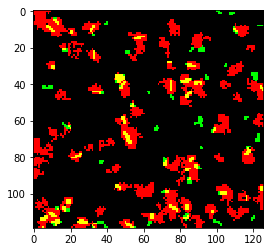

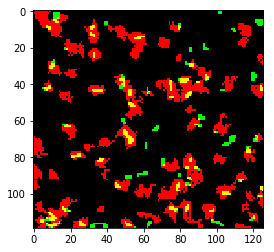

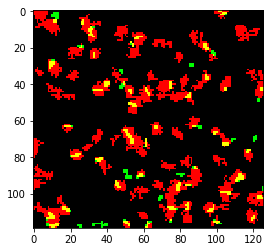

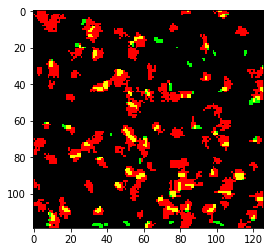

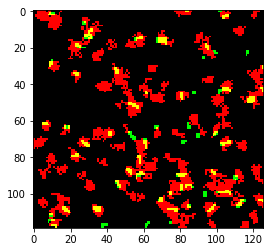

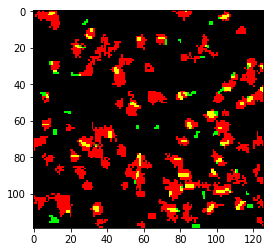

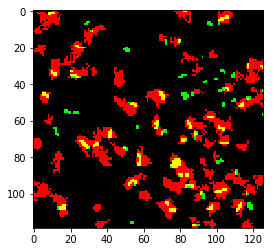

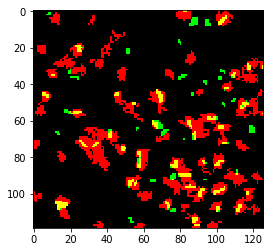

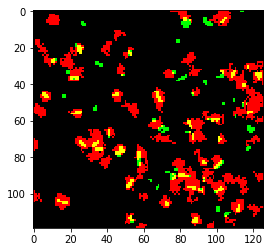

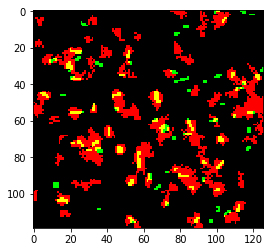

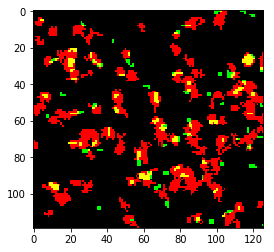

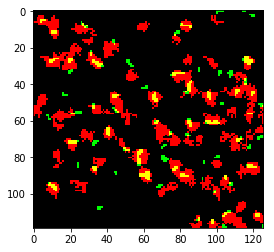

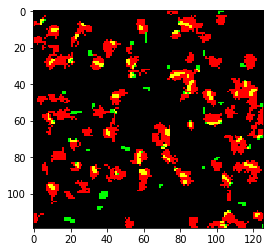

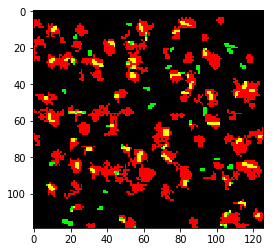

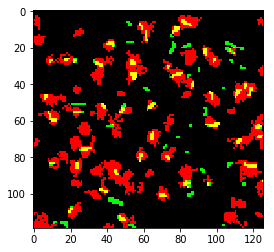

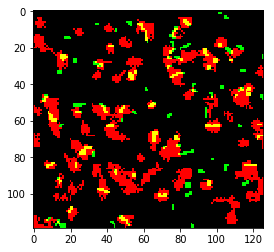

In [15]:
for idx, z_postproc in enumerate(full_postproc):
    plt.figure()
    img = make_overlap_img(z_postproc, full_gt[idx])
    plt.imshow(img)
    plt.show()

In [18]:
from skimage.measure import label
def get_b_per_a(a=None, b=None, disp=False):
    l_a = label(a > 0)
    l_b = label(b > 0)
    counts = []
    for a_idx in np.unique(l_a):
        #dont count background
        if a_idx != 0:
            rel_locs = [elem for elem in zip(*(np.where(l_a == a_idx)))]
            uniques = np.unique([l_b[elem] for elem in rel_locs])
            if disp:
                print(a_idx, '\t', uniques)
            count = len(uniques)
            
            if 0 in uniques:
                count -=1
            counts.append(count)
    return counts

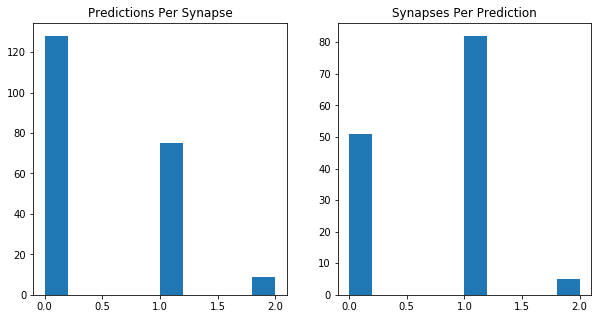

In [31]:
plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
ax.set_title('Predictions Per Synapse')
dist = []
dist = get_b_per_a(a=full_gt[1:-2] > 0, b=full_postproc[1:-2] > 0)
plt.hist(dist)
ax = plt.subplot(122)
ax.set_title('Synapses Per Prediction')
dist = get_b_per_a(b=full_gt[1:-2] > 0, a=full_postproc[1:-2] > 0)
dist = np.clip(dist, 0, 2)
plt.hist(dist)
plt.show()

In [18]:
print(test_set_predictions)

[[0.37268317 0.62731683]
 [0.6934263  0.30657378]
 [0.6321196  0.36788043]
 ...
 [0.2941834  0.7058166 ]
 [0.3349634  0.6650366 ]
 [0.27001783 0.72998214]]


In [19]:
print(test_set_predictions.shape)

(19347, 2)


In [20]:
print(test_labels)

[[False, True], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [False, True], [True, False], [True, False], [False, True], [True, False], [True, False], [True, False], [False, True], [True, False], [False, True], [False, True], [False, True], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [False, True], [True, False], [True, False], [False, True], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [False, True], [False, True], [False, True], [True, False], [False, True], [True, False], [False, True], [False, True], [True, False], [True, False], [True, False], [True, False], [False, True], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [False, True], [True, False], [True, False], [False, True], [True, False], [False, True], [False, True], [True, False], [True, Fa

In [21]:
print(full_postproc)

[[[ True  True  True ... False False False]
  [ True  True  True ... False False False]
  [ True  True  True ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False  True  True ... False False False]
  [ True  True  True ... False False False]
  [False  True  True ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[ True  True  True ... False False False]
  [ True  True  True ... False False False]
  [ True  True  True ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 ...

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False Fal

In [42]:
from skimage import measure
from skimage import filters
from skimage.morphology import binary_erosion

In [43]:
import numpy as np

In [44]:
eroded = binary_erosion(full_postproc, np.ones((3, 3, 3)))
synapse_labels = measure.label(eroded, background=0)

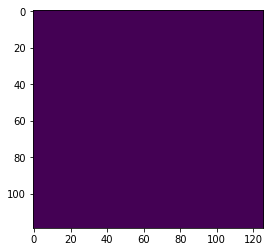

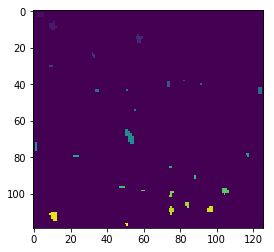

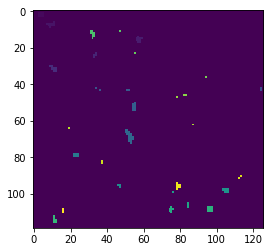

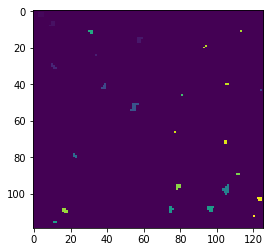

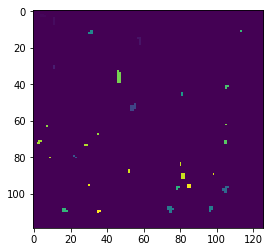

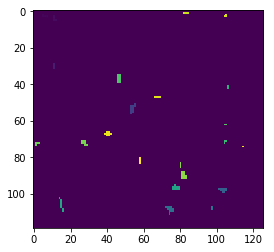

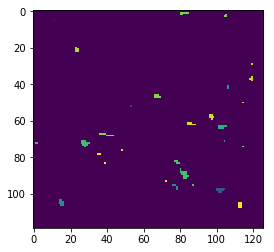

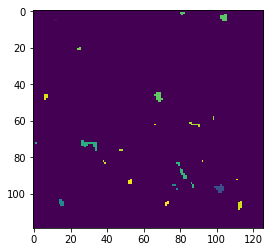

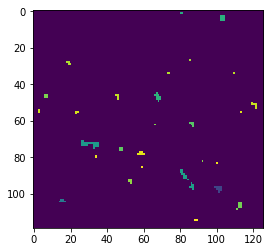

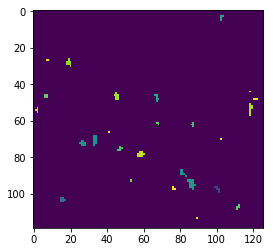

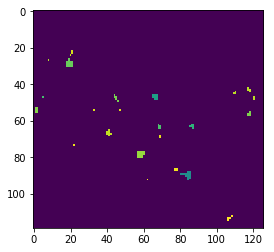

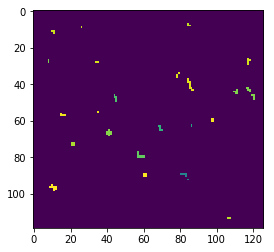

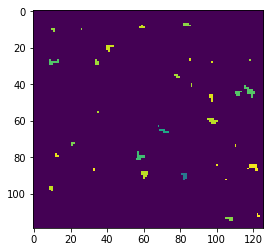

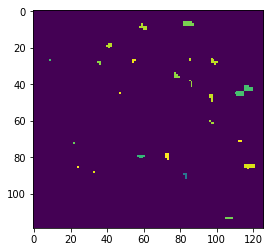

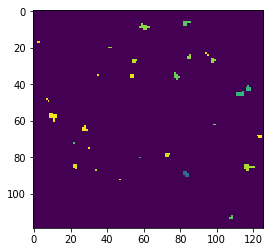

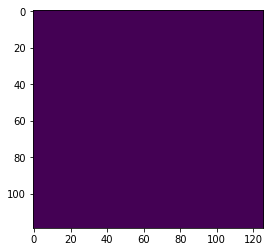

In [45]:
for i in range(synapse_labels.shape[0]):
    plt.figure()
    plt.imshow(synapse_labels[i])
    plt.show()

In [24]:
print(np.unique(synapse_labels))


[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148]


In [46]:
test = synapse_labels[0]
print(test[0][0])
print(np.unique(test))

0
[0]


In [47]:
connected_components = {}
for y in range(test.shape[0]):
    for x in range(test.shape[1]):
        if (test[y][x] in connected_components.keys()):
            connected_components[test[y][x]].append((y, x))
        else:
            connected_components[test[y][x]] = [(y, x)]

print(connected_components.keys())
connected_components.pop(0)

dict_keys([0])


[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 16),
 (0, 17),
 (0, 18),
 (0, 19),
 (0, 20),
 (0, 21),
 (0, 22),
 (0, 23),
 (0, 24),
 (0, 25),
 (0, 26),
 (0, 27),
 (0, 28),
 (0, 29),
 (0, 30),
 (0, 31),
 (0, 32),
 (0, 33),
 (0, 34),
 (0, 35),
 (0, 36),
 (0, 37),
 (0, 38),
 (0, 39),
 (0, 40),
 (0, 41),
 (0, 42),
 (0, 43),
 (0, 44),
 (0, 45),
 (0, 46),
 (0, 47),
 (0, 48),
 (0, 49),
 (0, 50),
 (0, 51),
 (0, 52),
 (0, 53),
 (0, 54),
 (0, 55),
 (0, 56),
 (0, 57),
 (0, 58),
 (0, 59),
 (0, 60),
 (0, 61),
 (0, 62),
 (0, 63),
 (0, 64),
 (0, 65),
 (0, 66),
 (0, 67),
 (0, 68),
 (0, 69),
 (0, 70),
 (0, 71),
 (0, 72),
 (0, 73),
 (0, 74),
 (0, 75),
 (0, 76),
 (0, 77),
 (0, 78),
 (0, 79),
 (0, 80),
 (0, 81),
 (0, 82),
 (0, 83),
 (0, 84),
 (0, 85),
 (0, 86),
 (0, 87),
 (0, 88),
 (0, 89),
 (0, 90),
 (0, 91),
 (0, 92),
 (0, 93),
 (0, 94),
 (0, 95),
 (0, 96),
 (0, 97),
 (0, 98),
 (0, 99),
 (0, 100),

In [48]:
synapse_centroids = []
for key, value in connected_components.items():
    y, x = zip(*value)
    synapse_centroids.append((int(sum(y)/len(y)), int(sum(x)/len(x))))

In [49]:
print(synapse_centroids)

[]


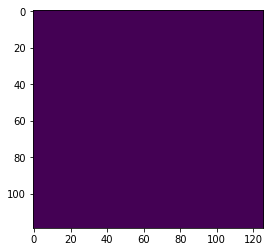

In [30]:
for elem in synapse_centroids:
    test[elem] = 255
    
plt.figure()
plt.imshow(test)
plt.show()

In [50]:
connected_components = {}
for z in range(synapse_labels.shape[0]):
    for y in range(synapse_labels.shape[1]):
        for x in range(synapse_labels.shape[2]):
            if (synapse_labels[z][y][x] in connected_components.keys()):
                connected_components[synapse_labels[z][y][x]].append((z, y, x))
            else:
                connected_components[synapse_labels[z][y][x]] = [(z, y, x)]

connected_components.pop(0)

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 0, 5),
 (0, 0, 6),
 (0, 0, 7),
 (0, 0, 8),
 (0, 0, 9),
 (0, 0, 10),
 (0, 0, 11),
 (0, 0, 12),
 (0, 0, 13),
 (0, 0, 14),
 (0, 0, 15),
 (0, 0, 16),
 (0, 0, 17),
 (0, 0, 18),
 (0, 0, 19),
 (0, 0, 20),
 (0, 0, 21),
 (0, 0, 22),
 (0, 0, 23),
 (0, 0, 24),
 (0, 0, 25),
 (0, 0, 26),
 (0, 0, 27),
 (0, 0, 28),
 (0, 0, 29),
 (0, 0, 30),
 (0, 0, 31),
 (0, 0, 32),
 (0, 0, 33),
 (0, 0, 34),
 (0, 0, 35),
 (0, 0, 36),
 (0, 0, 37),
 (0, 0, 38),
 (0, 0, 39),
 (0, 0, 40),
 (0, 0, 41),
 (0, 0, 42),
 (0, 0, 43),
 (0, 0, 44),
 (0, 0, 45),
 (0, 0, 46),
 (0, 0, 47),
 (0, 0, 48),
 (0, 0, 49),
 (0, 0, 50),
 (0, 0, 51),
 (0, 0, 52),
 (0, 0, 53),
 (0, 0, 54),
 (0, 0, 55),
 (0, 0, 56),
 (0, 0, 57),
 (0, 0, 58),
 (0, 0, 59),
 (0, 0, 60),
 (0, 0, 61),
 (0, 0, 62),
 (0, 0, 63),
 (0, 0, 64),
 (0, 0, 65),
 (0, 0, 66),
 (0, 0, 67),
 (0, 0, 68),
 (0, 0, 69),
 (0, 0, 70),
 (0, 0, 71),
 (0, 0, 72),
 (0, 0, 73),
 (0, 0, 74),
 (0, 0, 75),
 (0, 0, 76),
 (0, 0, 7

In [51]:
synapse_centroids = []
for key, value in connected_components.items():
    z, y, x = zip(*value)
    synapse_centroids.append((int(sum(z)/len(z)), int(sum(y)/len(y)), int(sum(x)/len(x))))
for elem in synapse_centroids:
    synapse_labels[elem] = 200

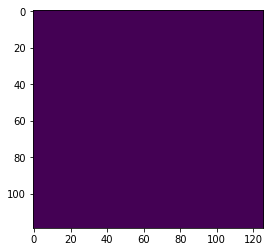

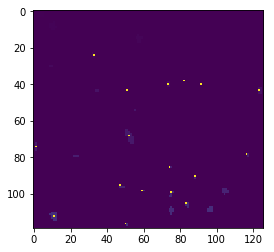

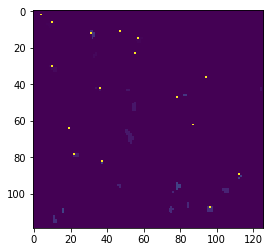

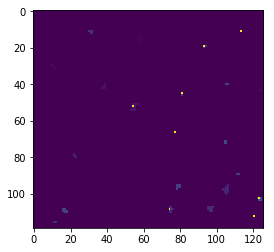

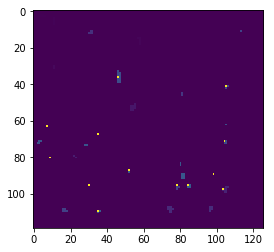

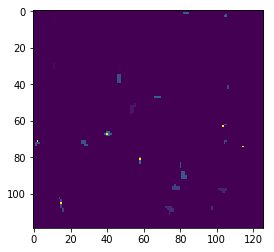

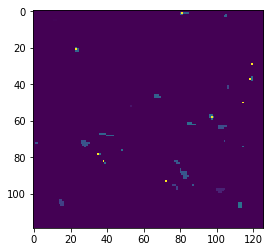

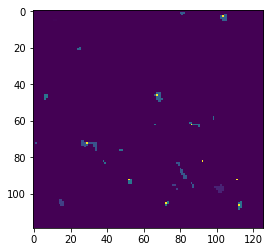

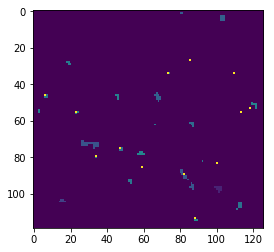

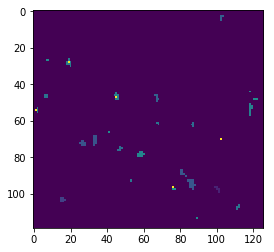

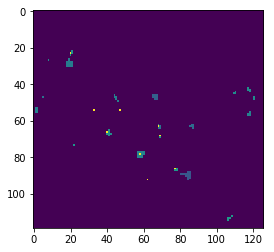

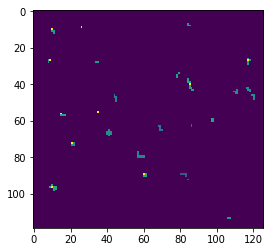

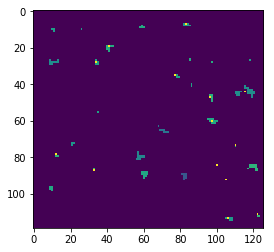

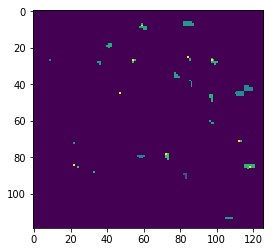

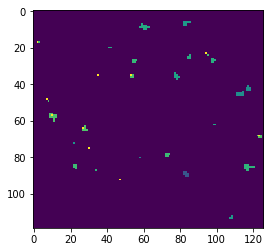

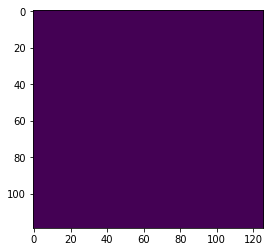

In [52]:
for i in range(synapse_labels.shape[0]):
    plt.figure()
    plt.imshow(synapse_labels[i])
    plt.show()

In [53]:
test = synapse_labels
test[np.where( test < 200 )] = 0
for idx, z_postproc in enumerate(full_postproc):
    plt.figure()
    img = make_overlap_img(test[idx], full_gt[idx])
    plt.imshow(img)
    plt.show()

ValueError: threshold_otsu is expected to work with images having more than one color. The input image seems to have just one color 0.

In [54]:
def get_aggregate_sum(synapse_centroids, data):
    z_max, y_max, x_max = data["PSD95"].shape
    data_dictionary = dict((key, []) for key in data.keys())
    for centroid in synapse_centroids:
        z, y, x = centroid
        z_lower = z - 11
        z_upper = z + 11
        y_lower = y - 11
        y_upper = y + 11
        x_lower = x - 11
        x_upper = x + 11
        # prob a better way but w/e tired rn
        # ignore boundary synapses
        if z_lower < 0 or z_upper >= z_max:
            continue
        if y_lower < 0 or y_upper >= y_max:
            continue
        if x_lower < 0 or x_upper >= x_max:
            continue
        for key in data.keys():
            data_dictionary[key].append(np.sum(data[key][z_lower:z_upper, y_lower:y_upper, x_lower: x_upper]))
    return data_dictionary

data_dict = get_aggregate_sum(synapse_centroids, data)

In [55]:
for key in data_dict.keys():
    print(len(data_dict[key]))

34
34
34
34
34
34
34
34
34


In [56]:
print(list(data_dict.items()))

[('GAD2', [878, 1326, 1547, 585, 2496, 837, 577, 1213, 1110, 1242, 1715, 1447, 874, 952, 1085, 2235, 967, 1292, 2396, 1874, 1356, 2107, 1403, 1390, 2312, 1146, 1483, 840, 2454, 1806, 1354, 2300, 1399, 2186]), ('GluN1', [1344, 2026, 1643, 1649, 2460, 1560, 1344, 2028, 1983, 1932, 2087, 2024, 1368, 1354, 1967, 2119, 1762, 2576, 2036, 1702, 2347, 2164, 2753, 2508, 1913, 1935, 2011, 1394, 2753, 2961, 2008, 1929, 1921, 1863]), ('synapsin', [1407, 1457, 2613, 1104, 1487, 989, 1588, 1205, 1224, 1433, 1389, 937, 1201, 1964, 1329, 1196, 2058, 1354, 1384, 1992, 1417, 2401, 1523, 1398, 1118, 1782, 1364, 1701, 1288, 1786, 1639, 1433, 1368, 1014]), ('MBP', [1, 415, 912, 2456, 1316, 3354, 2202, 4163, 1725, 0, 562, 1749, 1368, 2105, 30, 0, 1227, 0, 27, 1, 0, 0, 1799, 4327, 0, 0, 243, 2734, 423, 2126, 2199, 0, 1310, 530]), ('annotation', [70110336, 10078193, 99528639, 47088531, 20727626, 55820991, 88686402, 12537438, 6032201, 93833116, 33454862, 8826436, 117419678, 103631877, 82227088, 92059817, 38011

In [57]:
import pandas as pd
chan, features = zip(*list(data_dict.items()))
print(len(chan))
print(len(features))

9
9


In [58]:
df = pd.DataFrame(data_dict)
print(df)


    GABA  GAD2  Gephyrin  GluN1   MBP  PSD95  VGlut1  annotation  synapsin
0    510   878       907   1344     1   1652    1348    70110336      1407
1    907  1326      1871   2026   415   1789    1969    10078193      1457
2    645  1547      1788   1643   912   1986    1837    99528639      2613
3    745   585      1280   1649  2456    747    1705    47088531      1104
4   3655  2496      1792   2460  1316   1632    2726    20727626      1487
5   1464   837      1629   1560  3354   1212    1966    55820991       989
6    241   577      1613   1344  2202   1657    2358    88686402      1588
7    542  1213      1505   2028  4163    742    1951    12537438      1205
8    676  1110      1344   1983  1725   1034    1639     6032201      1224
9    253  1242      1379   1932     0   1313    1685    93833116      1433
10  2063  1715      1413   2087   562   1866    2334    33454862      1389
11  3001  1447      1586   2024  1749    704    2256     8826436       937
12   386   874      1526 

In [61]:
df = df.drop(["annotation"], axis = 1)

,GABA,GAD2,Gephyrin,GluN1,MBP,PSD95,VGlut1,synapsin
0,510,878,907,1344,1,1652,1348,1407
1,907,1326,1871,2026,415,1789,1969,1457
2,645,1547,1788,1643,912,1986,1837,2613
3,745,585,1280,1649,2456,747,1705,1104
4,3655,2496,1792,2460,1316,1632,2726,1487
5,1464,837,1629,1560,3354,1212,1966,989
6,241,577,1613,1344,2202,1657,2358,1588
7,542,1213,1505,2028,4163,742,1951,1205
8,676,1110,1344,1983,1725,1034,1639,1224
9,253,1242,1379,1932,0,1313,1685,1433


In [62]:
df.to_csv("pymeda.csv", sep='\t')